In [116]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [99]:
NYcrimeDf = pd.read_csv('NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013 - 13tbl8ny.csv', skiprows=4).fillna(0)
NYcrimeDf.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0.0,0.0,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,"2,577",3,0.0,0.0,0,0,3,24,3,20,1,0.0
2,Akron Village,"2,846",3,0.0,0.0,0,0,3,16,1,15,0,0.0
3,Albany,"97,956",791,8.0,0.0,30,227,526,"4,090",705,"3,243",142,0.0
4,Albion Village,"6,388",23,0.0,0.0,3,4,16,223,53,165,5,0.0


In [100]:
#Propertycrime = α + Population + Population2 + Murder + Robbery
#creating features using above variables
murder = 0

population = []
for x in NYcrimeDf['Population']:
    pop = str(x).replace(',','')
    population.append(int(pop))
    
Population = pd.DataFrame(population)
multivarReg = pd.DataFrame()
multivarReg['Population'] = Population[0]**(1/8)
multivarReg['Population^2'] = multivarReg['Population']**2


Murder_Cate = []
for key in NYcrimeDf['Murder and\nnonnegligent\nmanslaughter']:
    if key > 0:
        Murder_Cate.append(1)
    else:
        Murder_Cate.append(0)

multivarReg['Murder'] = Murder_Cate

robbery = []
for key in NYcrimeDf['Robbery']:
    rob = int(str(key).replace(',',''))
    
    if rob > 0:
        robbery.append(1)
    else:
        robbery.append(0)
multivarReg['Robbery'] = robbery

PropertyCrime = []
for x in NYcrimeDf['Property\ncrime']:
    propCrime = str(x).replace(',','')
    PropertyCrime.append(int(propCrime))

PropertyCrime = pd.DataFrame(PropertyCrime)
multivarReg['Property crime'] = np.log(PropertyCrime[0])

multivarReg.head()

C:\Users\ktser\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log


,Population,Population^2,Murder,Robbery,Property crime
0,2.562821,6.568052,0,0,2.484907
1,2.669250,7.124897,0,0,3.178054
2,2.702585,7.303966,0,0,2.772589
3,4.206093,17.691219,1,1,8.316300
4,2.989996,8.940076,0,1,5.407172


In [101]:
#Removing the values below because they are -infinity due to taking log of zero
i = multivarReg[multivarReg['Property crime'] <= 0].index.tolist()
i = i +[216, 346]

multivarReg = multivarReg.drop(i)


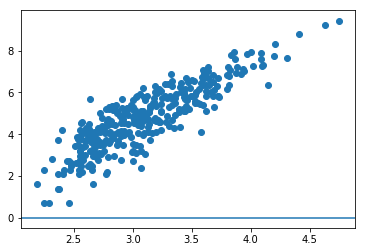

In [102]:
#comparing the linear relation of population feature and the outcome
#because model assumes linear relation
plt.scatter(multivarReg['Population'],multivarReg['Property crime'])
plt.axhline(y=0)
plt.show()

## Data modeling using sklearn

In [118]:
#the linear model
regr = linear_model.LinearRegression()

#Property crime, the outcome
Y_train = multivarReg['Property crime'].values.reshape(-1, 1)

#The independen variables, features
X_train = multivarReg[['Population','Murder', 'Robbery']]

model = regr.fit(X_train, Y_train)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_train, Y_train))



Coefficients: 
 [[ 2.28378037  0.23499398  0.85698579]]

Intercept: 
 [-2.84319579]

R-squared:
0.810192051293


In [25]:
# multivariable normality
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = multivarReg['Property crime']

# Calculate the error, also called the residual.
residual = actual - predicted


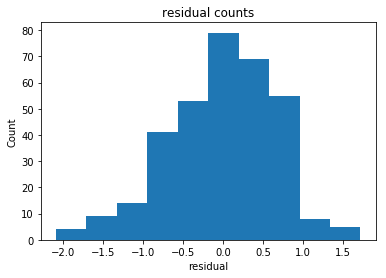

In [26]:
#Showing normal distribution of residual (a.k.a. error)
#Its improtant for the distribution to be normal, which means that each independent variables
#contributes equaly to the outcome.
plt.hist(residual)
plt.title('residual counts')
plt.xlabel('residual')
plt.ylabel('Count')
plt.show()

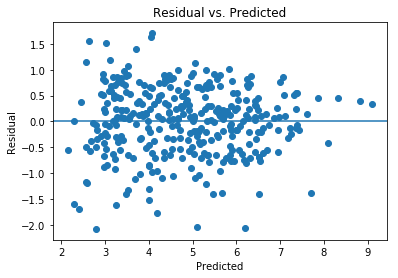

In [27]:
#Homoscedasticity
#Scedastic, meaning distribution of your error, needs to be consistent for all the predicted values.
#If not, that means different predicted outcomes have different errors and since confedance intervals
#is calculated using mean error squared. It will be skewed one way or the other.
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


<p>For the above analysis, I used the Population, Murder, and Robbery as the variables.</p>

<p>The initial analysis had high R^2, indicating high corrolation between input and output variables but the error did not have normal distribution and the error for outcome valuse varried greatly. This tell us that there are overfitting and the model is claming much higher accuracy than actualy is.</p>

<p>The model assumes a linear relation between outcome and input variables and that is not true. Since Murder and Robbery were categorical variables, there was nothing much to be done to create linear relations with the outcome. For the population variable I took 1/8 power of variable and natural log of the outcome (Property crime) to create linear relation and removing some outliers.For this reason, it was not practical to include population squred feature in the model, it has opposit effect of an linear relation.</p>

<p>After the transformation of the variables, the error distribution is normal, linear relation amongs the variables and the outcome, and the error variance is much lower and uniforme than initial analysis.</p>

# Data modeling using Statsmodels

In [109]:
import statsmodels.api as sm

C:\Users\ktser\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [113]:
#The outcome, "target"
Y_train = multivarReg['Property crime']

#The independen variables, features
X_train = multivarReg[['Population','Murder', 'Robbery']]
X_train = sm.add_constant(X_train)

model = sm.OLS(Y_train, X_train).fit()

# make the predictions by the model
predictions = model.predict(X_train) 

#print stats
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Property crime   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     473.8
Date:                Sat, 14 Jul 2018   Prob (F-statistic):          9.08e-120
Time:                        21:05:57   Log-Likelihood:                -339.17
No. Observations:                 337   AIC:                             686.3
Df Residuals:                     333   BIC:                             701.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8432      0.299     -9.497      0.000      -3.432      -2.254
Population     2.2838      0.106     21.551      0.000       2.075       2.492
Murder         0.2350      0.121      1.944      0.053      -0.003       0.473
Robbery        0.8570      0.090      9.472      0.000       0.679       1.035
==============================================================================
Omnibus:                       10.878   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               10.996
Skew:                          -0.424   Prob(JB):                      0.00409
Kurtosis:                       3.256   Cond. No.                         29.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Validating regression models for prediction

In [87]:
MAcrimeDf = pd.read_csv('offenses_known_to_law_enforcement_massachusetts_by_city_2013.csv', skiprows=4).fillna(0)
MAcrimeDf.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Unnamed: 13
0,Abington,"16,121",48,0.0,5.0,0.0,7,36,297,82,201,14,1.0,0.0
1,Acton,"22,871",8,0.0,1.0,0.0,2,5,178,31,144,3,0.0,0.0
2,Acushnet,"10,362",19,0.0,2.0,0.0,0,17,74,27,40,7,2.0,0.0
3,Adams,"8,352",21,0.0,3.0,0.0,3,15,157,40,109,8,1.0,0.0
4,Agawam,"28,659",41,0.0,12.0,0.0,3,26,270,105,130,35,1.0,0.0


In [88]:
#Propertycrime = α + Population + Population2 + Murder + Robbery
murder = 0

population = []
for x in MAcrimeDf['Population']:
    pop = str(x).replace(',','')
    population.append(int(pop))
    
Population = pd.DataFrame(population)
multivarReg2 = pd.DataFrame()

multivarReg2['Population'] = Population[0]**(1/8)
#multivarReg2['Population^2'] = multivarReg2['Population']**2

Murder_Cate = []
for key in MAcrimeDf['Murder and\nnonnegligent\nmanslaughter']:
    if key > 0:
        Murder_Cate.append(1)
    else:
        Murder_Cate.append(0)
multivarReg2['Murder'] = Murder_Cate

robbery = []
for key in MAcrimeDf['Robbery']:
    rob = int(str(key).replace(',',''))
    
    if rob > 0:
        robbery.append(1)
    else:
        robbery.append(0)
multivarReg2['Robbery'] = robbery

PropertyCrime = []
for x in MAcrimeDf['Property\ncrime']:
    propCrime = str(x).replace(',','')
    PropertyCrime.append(int(propCrime))

PropertyCrime = pd.DataFrame(PropertyCrime)
multivarReg2['Property crime'] = np.log(PropertyCrime[0])

multivarReg2.head()

C:\Users\ktser\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log


,Population,Murder,Robbery,Property crime
0,3.356789,0,1,5.693732
1,3.506797,0,1,5.181784
2,3.176365,0,0,4.304065
3,3.091888,0,1,5.056246
4,3.607095,0,1,5.598422


In [89]:
i = multivarReg2[multivarReg2['Property crime'] <= 0].index.tolist()
multivarReg2 = multivarReg2.drop(i)

In [90]:
#Property crime, the outcome
Y_test = multivarReg2['Property crime'].values.reshape(-1, 1)

#The independen variables, features
X_test = multivarReg2[['Population','Murder', 'Robbery']]

ols_model = -2.84319579 + x*2.28378037 + x*0.23499398 + x* 0.85698579

In [104]:
#make prediction based on earlier trained model
Y_pred = regr.predict(X_test)

#Print out the how much of the varience is explained by the features
print('\nR-squared:')
print(model.score(X_test, Y_test))


R-squared:
0.781203845437


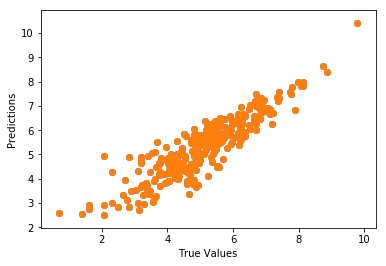

In [107]:
## The line / model
plt.scatter(Y_test, Y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

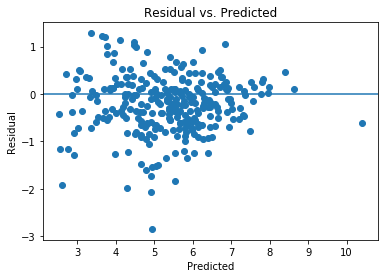

In [108]:
residual = Y_test - Y_pred
#Homoscedasticity
plt.scatter(Y_pred, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [119]:
print(cross_val_score(model, X_test, Y_test, cv=10))

[ 0.77229021  0.89266238  0.83202029  0.79445889  0.86760799  0.86244585
  0.79190621  0.78953171  0.79215695  0.81835741]
